# The COMPAS Project: A Computational Database of Polycyclic Aromatic Systems. Phase 2: _cata_-condensed Hetero-Polycyclic Aromatic Systems

## Benchmarking semi-empirical methods

# Summary
This Jupyter Notebook provides detailed calculations and analysis for the evaluation of semi-empirical methods in comparison to density functional theory (DFT) calculations. The benchmarking was performed on a random dataset of 1,000 cc-hPASs (conjugated heterocyclic aromatic systems).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
from pathlib import Path

from utils.func import get_metrics, get_metrics_df

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

DATA_FOLDER = Path('data')
FIGURE_FOLDER = Path('figures')
FIGURE_S1 = FIGURE_FOLDER / 'figure_s1'
BENCHMARK_FOLDER = DATA_FOLDER / 'benchmark'

FIGURE_S1.mkdir(exist_ok=True,parents=True)

# Benchmarking of semi-empirical Methods

## Dataset Preparation
Selection of Benchmark Set:

- A random dataset of 1,000 cc-hPASs was chosen as the benchmark set for the study.

Geometry Optimization:

- The geometries of the benchmark molecules were optimized at the CAM-B3LYP-D3BJ/def2-SVP level of theory using DFT calculations.
    - Vibrational frequencies were calculated for the optimized geometries to ensure that the geometries corresponded to energetic minima.
- For each molecule, the HOMO and LUMO energy values were extracted from the DFT-optimized geometries.

In [2]:
df_dft = pd.read_csv(BENCHMARK_FOLDER / 'db-benchmark-998-dft.csv')

df_dft.head()

name       energy    homo    lumo
0  C2M302879 -1564.460698 -6.6549 -2.0753
1  C2M281316 -1487.141100 -5.7074 -0.6796
2  C2M285490 -2128.561781 -6.9179 -2.2877
3  C2M285959 -1965.813979 -6.0680 -1.8387
4  C2M286386 -1905.729547 -6.3326 -0.6418

## semi-empirical Methods

Several semi-empirical methods were selected for evaluation: GFN1-xTB, GFN2-xTB, PM6, and PM7. The methods were implemented using the xTB (v6.5.1.27) and MOPAC software suites.

In [3]:
# Load the semi-empirical data
df_gfn1 = pd.read_csv(BENCHMARK_FOLDER / 'db-benchmark-998-gfn1.csv')
df_gfn2 = pd.read_csv(BENCHMARK_FOLDER / 'db-benchmark-998-gfn2.csv')
df_pm6 = pd.read_csv(BENCHMARK_FOLDER / 'db-benchmark-998-pm6.csv')
df_pm7 = pd.read_csv(BENCHMARK_FOLDER / 'db-benchmark-998-pm7.csv')

# add _{method} to the column names of each dataframe
for df, suff in zip([df_gfn1, df_gfn2, df_pm6, df_pm7, df_dft], ['_gfn1', '_gfn2', '_pm6', '_pm7', '_dft']):
    df.columns = [f'{col}{suff}' if col != 'name' else col for col in df.columns ]
    # sort by name
    df.sort_values(by='name', inplace=True)   
    df.reset_index(drop=True, inplace=True)

# concat all dataframes into one
df = pd.concat([df_gfn1, df_gfn2, df_pm6, df_pm7, df_dft], axis=1)
df.head()

# remove duplicate columns (name)
df = df.loc[:,~df.columns.duplicated()]


## Evaluation Metrics
- Various evaluation metrics were used to assess the agreement between the semi-empirical methods and DFT values.
- The evaluation metrics included: `R^2`, `RMSE`, `MAE`, `MSE`, `Pearson's coefficient`, and `variance`.


In [4]:
df_metrics = get_metrics_df(df)
df_metrics

0           1          2           3          4         5  \
method   homo_gfn1   lumo_gfn1  homo_gfn2   lumo_gfn2   homo_pm6  lumo_pm6   
r2      -89.998882 -157.122768 -49.124758 -121.478261 -15.890078  0.590884   
rmse      4.084857    7.488228   3.031691    6.590394   1.759846  0.380895   
mae       4.078661    7.486199   3.008357     6.58602    1.74626  0.318371   
mse      16.686053   56.073557    9.19115   43.433288   3.097057  0.145081   
pearson   0.882783    0.980745   0.488659    0.940765   0.880201  0.837793   
var       0.050577    0.030377   0.140938    0.057626   0.047633  0.137983   

                 6         7  
method    homo_pm7  lumo_pm7  
r2      -15.504276  0.727453  
rmse      1.739631  0.310887  
mae       1.725372  0.251317  
mse       3.026315  0.096651  
pearson    0.86922  0.924068  
var       0.049405   0.08808

## Comparison with DFT Values
- The same properties (HOMO and LUMO energies) were calculated using the semi-empirical methods with the DFT-optimized geometries.
- Scatter plots were generated to compare the results of each method against the corresponding DFT values (see Figure 1).


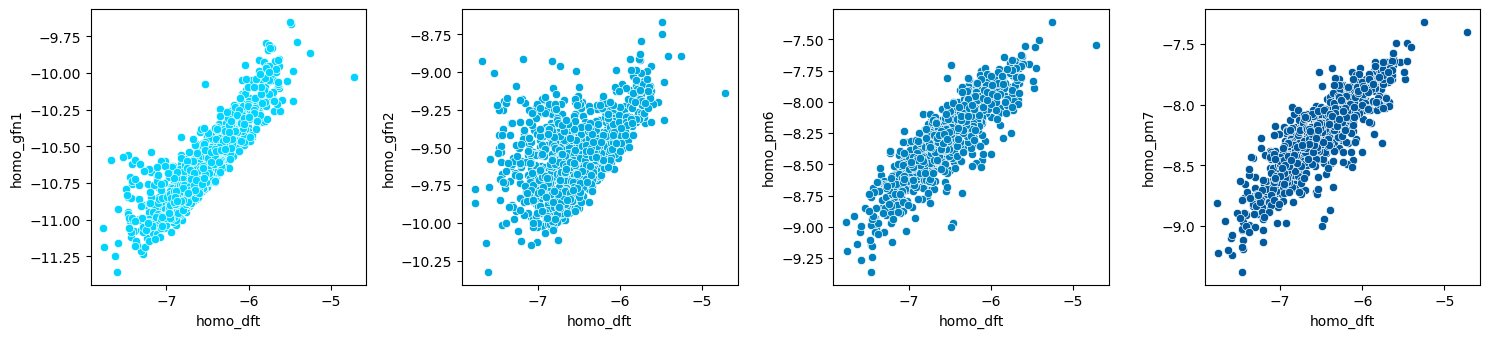

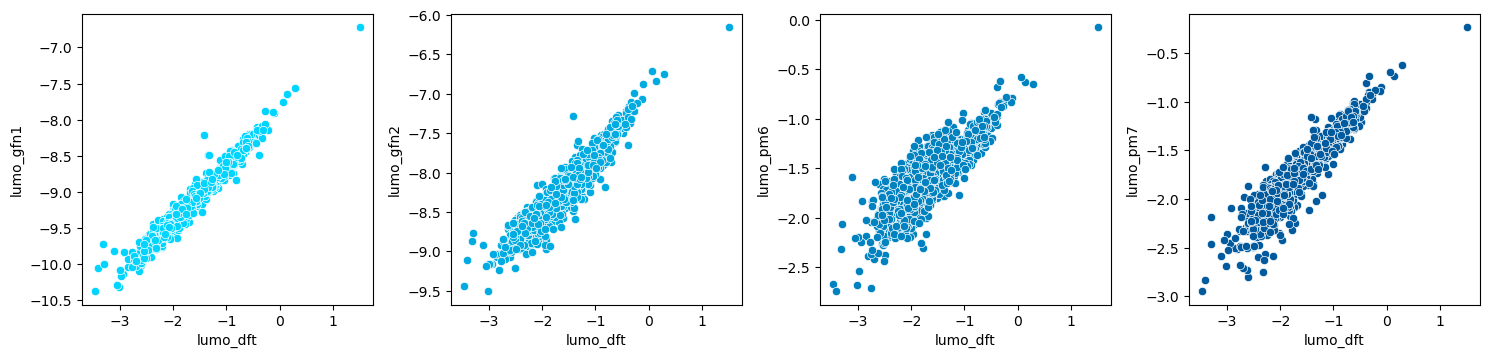

In [5]:
# Set limits for x-axis and y-axis for HOMO scatter plot
homo_xtb_limits = [[-8, -4], [-12, -7]]
homo_pm_limits = [[-8, -4], [-10, -6]]

# Set limits for x-axis and y-axis for LUMO scatter plot
lumo_xtb_limits = [[-4, 2], [-11, -6]]
lumo_pm_limits = [[-4, 2], [-3, 0]]

colors = {
    "gfn1": "#01D5FF",
    "gfn2": "#00ABE2",
    "pm6": "#0082C1",
    "pm7": "#005A9D",
}

# Function to generate scatter plot for a given property
def generate_scatter_plot(df, ref_property, properties, limits, figure_name):
    fig_all, axs = plt.subplots(1, len(properties), figsize=(15, 5))
    for i, method in enumerate(properties):
        fig, ax = plt.subplots(figsize=(4, 4), dpi=400)
        color = colors[method.split("_")[-1]]
        sns.scatterplot(x=ref_property, y=method, data=df, ax=ax, color=color)
        sns.scatterplot(x=ref_property, y=method, data=df, ax=axs.flatten()[i], color=color)
        axs.flatten()[i].set_box_aspect(1)
        ax.set_xlim(*limits[0])
        ax.set_ylim(*limits[1])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_box_aspect(1)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        plt.savefig(FIGURE_S1 / f"{figure_name}_{method.split('_')[-1]}.png", transparent=True, dpi=400)
        plt.close(fig)
    fig_all.tight_layout()

# Generate HOMO scatter plot
ref_homo = 'homo_dft'
apr_homo = ['homo_gfn1', 'homo_gfn2', 'homo_pm6', 'homo_pm7']
generate_scatter_plot(df, ref_homo, apr_homo, homo_xtb_limits if 'gfn' in apr_homo[0] else homo_pm_limits, "homo_benchmark")

# Generate LUMO scatter plot
ref_lumo = 'lumo_dft'
apr_lumo = ['lumo_gfn1', 'lumo_gfn2', 'lumo_pm6', 'lumo_pm7']
generate_scatter_plot(df, ref_lumo, apr_lumo, lumo_xtb_limits if 'gfn' in apr_lumo[0] else lumo_pm_limits, "lumo_benchmark")



## Method Selection

- The evaluation metrics were used to select a suitable semi-empirical method for further analysis.
- The linearity of the correlation (measured by the Pearson coefficient) was considered a crucial factor.
- GFN1-xTB exhibited the best performance in terms of linearity, suggesting its superior regression capabilities.
- GFN2-xTB showed a low Pearson coefficient for HOMO energy.
- PM6 and PM7 exhibited high Pearson coefficients but lacked total energy values.
- GFN1-xTB was selected for further analysis based on these considerations.


# Conclusion
This Jupyter Notebook provides a comprehensive analysis of the benchmarking and method selection process for semi-empirical methods in comparison to DFT calculations. It serves as a valuable resource for researchers interested in evaluating and selecting suitable semi-empirical methods for heterocyclic aromatic systems.

Please refer to the original paper and supplementary information for more details on the methodology and results.